In [1]:
import os
import re
import pickle
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import pandas as pd
import torch
import tifffile
from sklearn.metrics import adjusted_rand_score
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom, DEFAULT_CONFIG
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils
import mushroom.data.datasets as datasets

In [5]:
project_dir = '/data/estorrs/mushroom/data/projects/submission_v1'
output_dir = os.path.join(project_dir, 'analysis', 'kidney')
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [6]:
sorted(utils.listfiles(os.path.join(project_dir, 'kidney'), regex=r'config.yaml$'))


['/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK12F-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK12M-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK3F-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK3M-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92F2-Fc1U1Bs2/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92M-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK92M1-Fc1U1Bs2/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/P1F1MnR-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submission_v1/kidney/P1M3MnR-Fp1/mushroom/config.yaml',
 '/data/estorrs/mushroom/data/projects/submissio

###### P21_F2RM6R

In [14]:
case = 'P21_F2RM6R'

mushroom_dir = os.path.join(project_dir, 'kidney', case, 'mushroom')
output_dir = os.path.join(output_dir, case)
Path(output_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(os.path.join(mushroom_dir, 'config.yaml')))
config

{'dtype_specific_params': {'visium': {'trainer_kwargs': {'target_resolution': 0.01,
    'tiling_method': 'radius'}}},
 'dtype_to_chkpt': {'multiplex': '/data/estorrs/mushroom/data/projects/submission_v1/kidney/P21_F2RM6R/mushroom/multiplex_chkpts/last.ckpt'},
 'sae_kwargs': {'codebook_dim': 64,
  'dtype_to_decoder_dims': {'cosmx': [256, 512, 1024],
   'he': [256, 128, 10],
   'multiplex': [256, 128, 64],
   'points': [256, 512, 1024],
   'visium': [256, 512, 2048],
   'xenium': [256, 256, 256]},
  'encoder_dim': 128,
  'neigh_scaler': 0.01,
  'num_clusters': [8, 4, 2],
  'patch_size': 1,
  'recon_scaler': 1.0,
  'size': 8},
 'sections': [{'data': [{'dtype': 'multiplex',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/kidney/P21_F2RM6R/registered/P21_F2RM6R_multiplex.ome.tiff'}],
   'position': 0,
   'sid': 'P21_F2RM6R-U1'}],
 'trainer_kwargs': {'accelerator': 'gpu',
  'batch_size': 128,
  'channel_mapping': {},
  'data_mask': None,
  'devices': 1,
  'input_resoluti

###### NMK12F-Fp1 (xenium)

In [7]:
case = 'NMK12F-Fp1'

mushroom_dir = os.path.join(project_dir, 'kidney', case, 'mushroom')
output_dir = os.path.join(output_dir, case)
Path(output_dir).mkdir(parents=True, exist_ok=True)

config = yaml.safe_load(open(os.path.join(mushroom_dir, 'config.yaml')))
config

{'dtype_specific_params': {'visium': {'trainer_kwargs': {'target_resolution': 0.01,
    'tiling_method': 'radius'}}},
 'dtype_to_chkpt': {'xenium': '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK12F-Fp1/mushroom/xenium_chkpts/last-v3.ckpt'},
 'sae_kwargs': {'codebook_dim': 64,
  'dtype_to_decoder_dims': {'cosmx': [256, 512, 1024],
   'he': [256, 128, 10],
   'multiplex': [256, 128, 64],
   'points': [256, 512, 1024],
   'visium': [256, 512, 2048],
   'xenium': [256, 256, 256]},
  'encoder_dim': 128,
  'neigh_scaler': 0.01,
  'num_clusters': [8, 4, 2],
  'patch_size': 1,
  'recon_scaler': 1.0,
  'size': 8},
 'sections': [{'data': [{'dtype': 'xenium',
     'filepath': '/data/estorrs/mushroom/data/projects/submission_v1/kidney/NMK12F-Fp1/registered/NMK12F-Fp1_xenium.h5ad'}],
   'position': 0,
   'sid': 'NMK12F-Fp1-U1'}],
 'trainer_kwargs': {'accelerator': 'gpu',
  'batch_size': 128,
  'channel_mapping': {},
  'data_mask': None,
  'devices': 1,
  'input_resolution': 1.0,
  '

## analysis from direct outputs

In [9]:
outputs = pickle.load(open(os.path.join(mushroom_dir, 'outputs.pkl'), 'rb'))
outputs.keys()

dict_keys(['section_positions', 'section_ids', 'dtype_to_volume', 'dtype_to_volume_probs', 'dtype_to_clusters', 'dtype_to_cluster_probs', 'dtype_to_cluster_probs_all', 'dtype_to_cluster_intensities'])

In [10]:
clusters = outputs['dtype_to_clusters']['xenium']
clusters[0].shape

(1, 60, 84)

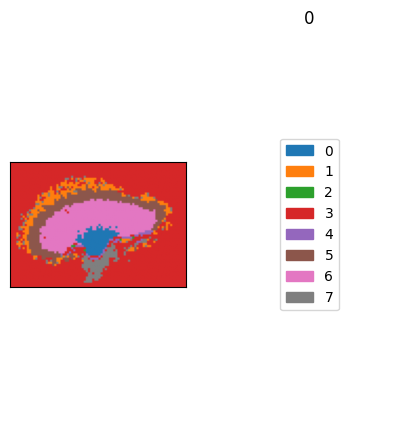

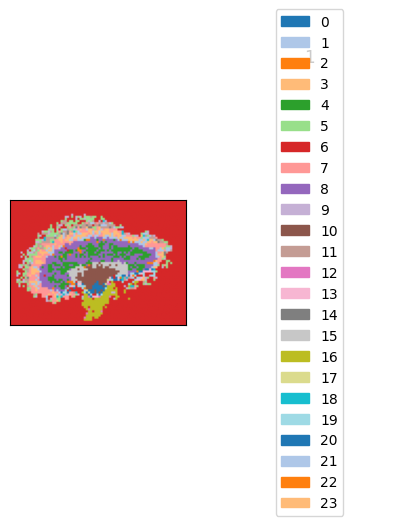

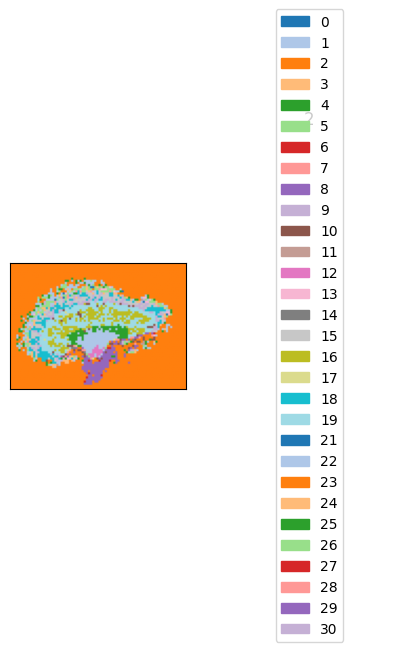

In [14]:
for i, x in enumerate(clusters):
    vis_utils.display_clusters(x, preserve_indices=True, figsize=(5,5))
    plt.title(i)

In [ ]:
vis_utils.display_clusters(clusters[0], preserve_indices=True)

## analysis with mushroom

In [8]:
mushroom = Mushroom.from_config(mushroom_dir, accelerator='cpu')

INFO:root:loading spore for xenium
INFO:root:singleton section detected, creating temporary duplicate
INFO:root:data mask detected
INFO:root:starting xenium processing
INFO:root:using 479 channels
INFO:root:2 sections detected: ['NMK12F-Fp1-U1', 'NMK12F-Fp1-U1_dup']
INFO:root:processing sections
INFO:root:generating image data for section NMK12F-Fp1-U1
INFO:root:generating image data for section NMK12F-Fp1-U1_dup

KeyboardInterrupt



In [17]:
mushroom.dtype_to_spore['multiplex'].clusters[0].shape

(1, 548, 356)

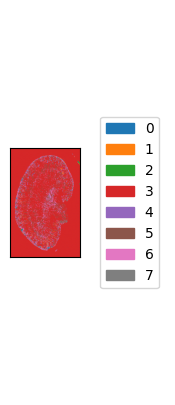

In [20]:
mushroom.display_clusters('multiplex', level=0)

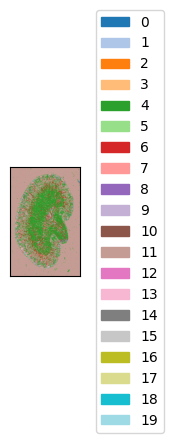

In [21]:
mushroom.display_clusters('multiplex', level=1)

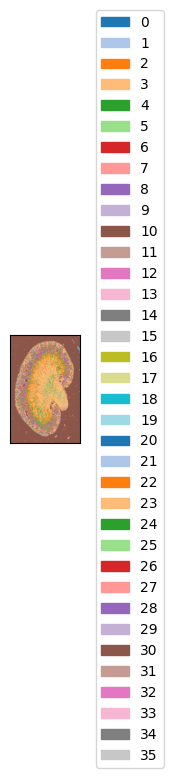

In [23]:
mushroom.display_clusters('multiplex', level=2)